In [1]:
using Random
using SSM
using Distributions
using Plots
using StatsBase

In [2]:
"""
Generate Synthetic Exponential Kernels
"""

# generate data from a "switching gaussian regression"
n = 500
K = 2
R = 100
X = Array{Matrix{Float64}}(undef, R)
S = Array{Vector{Float64}}(undef, R)
Y = Array{Vector{Float64}}(undef, R);

# Exponential

A = [0.9 0.1; 0.05 0.95]
β₁ = exp.(LinRange(-10, 0, 50)) ./ (sum(exp.(LinRange(-10, 0, 50)) * mean(diff(LinRange(-15, 0, 50)))))
β₂ = exp.(LinRange(-4, 0, 50)) ./ (sum(exp.(LinRange(-4, 0, 50)) * mean(diff(LinRange(-4, 0, 50)))))
σ²₁, σ²₂ = 1.0, 1.0;

init_state = Vector{Int}(undef, R)

for ii = 1:R

    x = cat(zeros(50), randn(n, 1), dims=1);
    XX = permutedims(hcat([x[i:i+50-1] for i in 1:n]...), (2,1))

    YY = zeros(n)
    SS = zeros(Int, n)
    
    for i in 1:n
        
        if i == 1
            SS[i] = StatsBase.sample(1:K, Weights([0.5, 0.5]))
            init_state[ii] = SS[i]
        else
            SS[i] = StatsBase.sample(1:K, Weights(A[SS[i-1], :]))
        end

        if SS[i] == 1
            YY[i] = XX[i, :]'*β₁ + rand(Normal(0, sqrt(σ²₁)))
        elseif SS[i] == 2
            YY[i] = XX[i, :]'*β₂ + rand(Normal(0, sqrt(σ²₂)))
        end
    end

    X[ii] = XX;
    Y[ii] = YY;
    S[ii] = SS;
end




In [3]:
function calculate_initial_state_probabilities(init_state::Vector{Int}, num_states::Int)
    state_counts = zeros(Int, num_states)
    total_trials = length(init_state)
    
    for state in init_state
        state_counts[state] += 1
    end
    
    initial_state_probabilities = state_counts / total_trials
    return initial_state_probabilities
end

# Example usage
num_states = 2  # Assuming there are 2 states
init_state_probabilities = calculate_initial_state_probabilities(init_state, num_states)
println("Initial state probabilities: ", init_state_probabilities)


Initial state probabilities: [0.5, 0.5]


In [4]:
model = SwitchingGaussianRegression(;K=2, λ=1e-12)
ll, A_stor, π_stor, β1_stor, β2_stor, σ1_stor, σ2_stor = SSM.fit!(model, X, Y, 75, 1e-6, true);


Log-Lieklihood at iter 1: -557876.5814946803
Log-Lieklihood at iter 2: -86763.08409224324
Log-Lieklihood at iter 3: -84773.33557176052
Log-Lieklihood at iter 4: -83569.48528853965
Log-Lieklihood at iter 5: -81699.27559088066
Log-Lieklihood at iter 6: -80020.1504809943
Log-Lieklihood at iter 7: -79194.47026895113
Log-Lieklihood at iter 8: -78908.390071097
Log-Lieklihood at iter 9: -78818.71348672673
Log-Lieklihood at iter 10: -78790.438219321
Log-Lieklihood at iter 11: -78781.29775799169
Log-Lieklihood at iter 12: -78778.2638272775
Log-Lieklihood at iter 13: -78777.22755926596
Log-Lieklihood at iter 14: -78776.86179918364
Log-Lieklihood at iter 15: -78776.72778566284
Log-Lieklihood at iter 16: -78776.6767242288
Log-Lieklihood at iter 17: -78776.65661856232
Log-Lieklihood at iter 18: -78776.64862707263
Log-Lieklihood at iter 19: -78776.64562032624
Log-Lieklihood at iter 20: -78776.64476496322
Log-Lieklihood at iter 21: -78776.64487558384
Log-Lieklihood at iter 22: -78776.64543173306
Log-

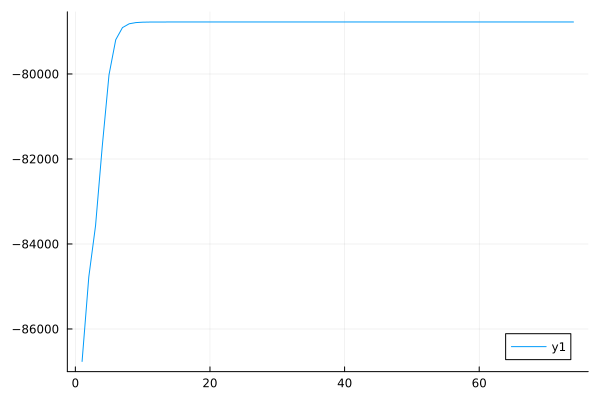

In [5]:
plot(ll[3:end])

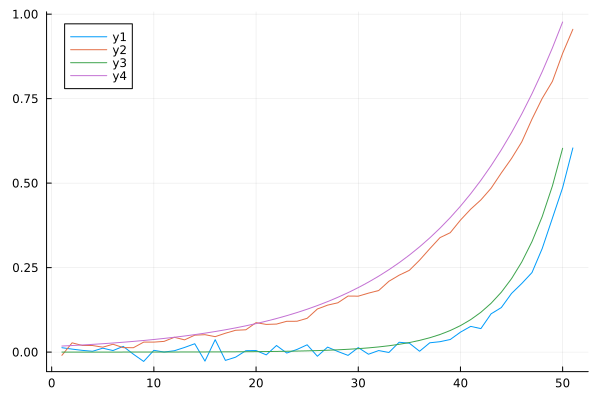

In [6]:
plot(model.B[1].regression.β)
plot!(model.B[2].regression.β)
plot!(β₁)
plot!(β₂)

In [7]:
println(model.A)
println(model.πₖ)

[0.37487630571713676 0.6251236942828632; 0.1896528268115344 0.8103471731884656]
[0.4843089949846757, 0.5156910050153244]
